In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import h5py
import scipy.special as sc
from data_analysis_codes.tools import Ricci_CoGrad_Weyl as RCW_file
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import FD as FD_file
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)
home_path = '/home/robynm/simulations/Geometrical/'
sciama_path = '/mnt/lustre/munozr/runs/Geometrical/'
path = sciama_path
simname = 'Szekeres'

In [2]:
# LCDM background
h              = 0.6737
c              = 1
G              = 1
kappa          = 8*np.pi*G
a_today        = 1
Hprop_today    = (h*c)/2997.9
t_today_EdS    = 2/(3*Hprop_today)
Omega_m_today  = 0.3147
rho_flrw_today = (3*Omega_m_today*Hprop_today**2)/kappa
Omega_l_today  = 1 - Omega_m_today
Lambda         = Omega_l_today*3*(Hprop_today**2)/(c**2)
def a(t):
    return a_today*(Omega_m_today/Omega_l_today)**(1/3)*np.sinh(np.sqrt(Omega_l_today)*t/t_today_EdS)**(2/3)
def dta(t):
    return Hprop(t)*a(t)
def dtdta(t):
    return dta(t)*Hprop(t)+a(t)*dtHprop(t)#((Lambda/3)-(kappa*rho_flrw(t)/6))
def at(tau):
    return a_today*(Omega_m_today/Omega_l_today)**(1/3)*np.sinh(tau)**(2/3)
def dtaua(tau):
    return (2/3)*atau(tau)*np.cosh(tau)/np.sinh(tau)
def Hprop(t):
    return Hprop_today * np.sqrt( Omega_m_today/((a(t)/a_today)**3) + Omega_l_today )
def dtHprop(t):
    return -3*Omega_m_today*dta(t)*(a_today**3)*(a(t)**(-4))*(Hprop_today**2)/(2*Hprop(t))
def Omega_m(t):
    return Omega_m_today / ( Omega_m_today + Omega_l_today*((a(t)/a_today)**3) )
def rho_flrw(t):
    return rho_flrw_today/a(t)**3

In [3]:
ic = 4
allNs = list(np.arange(88, 170, 8))
meanerror_4R = []
meanerror_B2 = []
meanerror_BT = []
meanerror_E2 = []
meanerror_ET = []
for N in allNs:
    # Generate data
    L = 20
    dx = L/N
    xyz = np.arange(-L/2, L/2, dx)[:N]
    xyz = xyz.astype('float128')
    x, y, z = np.meshgrid(xyz, xyz, xyz, indexing='ij')
    Box_zero = np.zeros([N, N, N])
    Box_ones = np.ones([N, N, N])
    
    Amp = 1000
    k = 2*np.pi/L
    tauC = np.sqrt(3*Lambda/4)
    betaP = Amp*(1-np.sin(k*z))
    dzbetaP = -k*Amp*np.cos(k*z)
    betaM = 0
    B = (3/4)*(Hprop_today**2)*(Omega_l_today*(Omega_m_today**2))**(1/3)
    A = 1+B*betaP*(x**2+y**2)
    
    RRead.BASH('mkdir '+path+simname+'_N'+str(N))
    RRead.BASH('mkdir '+path+simname+'_N'+str(N)+'/all_iterations')    
    dtfac = 0.05
    dt = dx*dtfac
    t_array = np.arange(1.5-ic*dt, 1.5+dt, dt)
    for it, t in enumerate(t_array):
        tau = tauC*t
        fM = np.cosh(tau)/np.sinh(tau)
        hyperthing = sc.hyp2f1(5/6, 3/2, 11/6, -np.sinh(tau)**2) 
        integrated_part = (3/5)*np.sqrt(np.cosh(tau)**2)*hyperthing*(np.sinh(tau)**(5/3))/np.cosh(tau)
        fP = fM*integrated_part
        dtaufM = -1/np.sinh(tau)**2
        dtfM = tauC*dtaufM
        part_to_integrate = (np.sinh(tau)**(2/3))/np.cosh(tau)**2
        dtaufP = dtaufM*integrated_part+fM*part_to_integrate
        dtfP = tauC*dtaufP
        dtaudtaufM = 2*np.cosh(tau)/np.sinh(tau)**3
        dtdtfM = (tauC**2)*dtaudtaufM
        dtau_part_to_integrate = (2/3)*(np.sinh(tau)**(-1/3))*(np.cosh(tau)**(-1))-2*(np.sinh(tau)**(5/3))*(np.cosh(tau)**(-3))
        dtaudtaufP = dtaudtaufM*integrated_part+2*dtaufM*part_to_integrate+fM*dtau_part_to_integrate
        dtdtfP = (tauC**2)*dtaudtaufP

        F     = betaM*fM + betaP*fP
        dzF   = dzbetaP*fP
        Z     = F + A
        dxZ   = 2*B*betaP*x
        dxdxZ = 2*B*betaP
        dyZ   = 2*B*betaP*y
        dydyZ = 2*B*betaP
        dzZ   = dzF + B*dzbetaP*(x**2+y**2)
        dtZ   = betaM*dtfM + betaP*dtfP
        dtdtZ = betaM*dtdtfM + betaP*dtdtfP

        delta =  -F/Z
        rho =  rho_flrw(t)*(1+delta)

        gdown = (a(t)**2)*np.array([[Box_ones, Box_zero, Box_zero],
                                    [Box_zero, Box_ones, Box_zero],
                                    [Box_zero, Box_zero, Z**2]])

        Kdown = -(a(t)**2)*np.array([[Box_ones*Hprop(t), Box_zero,          Box_zero],
                                     [Box_zero,          Box_ones*Hprop(t), Box_zero],
                                     [Box_zero,          Box_zero,          (Z**2)*(Hprop(t)+dtZ/Z)]])
        
        fname = path+simname+'_N'+str(N)+'/all_iterations/'+simname+'_it_{:06d}.hdf5'.format(it)
        with h5py.File(fname, 'w') as fnew:
            fnew['gxx it={}'.format(it)] = gdown[0,0]
            fnew['gxy it={}'.format(it)] = gdown[0,1]
            fnew['gxz it={}'.format(it)] = gdown[0,2]
            fnew['gyy it={}'.format(it)] = gdown[1,1]
            fnew['gyz it={}'.format(it)] = gdown[1,2]
            fnew['gzz it={}'.format(it)] = gdown[2,2]
            fnew['kxx it={}'.format(it)] = Kdown[0,0]
            fnew['kxy it={}'.format(it)] = Kdown[0,1]
            fnew['kxz it={}'.format(it)] = Kdown[0,2]
            fnew['kyy it={}'.format(it)] = Kdown[1,1]
            fnew['kyz it={}'.format(it)] = Kdown[1,2]
            fnew['kzz it={}'.format(it)] = Kdown[2,2]
            
    RRead.BASH("""printf "%s\n" "simname  = '"""+simname+"""'" "N = """+str(N)+"""" "L = """+str(L)+"""" "dtfac = """+str(dtfac)+"""" "boundary = False" "data_path = '"""+path+simname+'_N'+str(N)+"""/'"> data_analysis_codes/EBWeylparam.py""")
    RRead.BASH("python data_analysis_codes/EBWeyl_test.py")
    
    t = 1.5
    it = np.argmin(abs(t_array-t))
    fname = path+simname+'_N'+str(N)+'/EBWeyl/it={:06d}.hdf5'.format(it)
    f = h5py.File(fname, 'r')
    
    tau = tauC*t
    fM = np.cosh(tau)/np.sinh(tau)
    hyperthing = sc.hyp2f1(5/6, 3/2, 11/6, -np.sinh(tau)**2) 
    integrated_part = (3/5)*np.sqrt(np.cosh(tau)**2)*hyperthing*(np.sinh(tau)**(5/3))/np.cosh(tau)
    fP = fM*integrated_part
    dtaufM = -1/np.sinh(tau)**2
    dtfM = tauC*dtaufM
    part_to_integrate = (np.sinh(tau)**(2/3))/np.cosh(tau)**2
    dtaufP = dtaufM*integrated_part+fM*part_to_integrate
    dtfP = tauC*dtaufP
    dtaudtaufM = 2*np.cosh(tau)/np.sinh(tau)**3
    dtdtfM = (tauC**2)*dtaudtaufM
    dtau_part_to_integrate = (2/3)*(np.sinh(tau)**(-1/3))*(np.cosh(tau)**(-1))-2*(np.sinh(tau)**(5/3))*(np.cosh(tau)**(-3))
    dtaudtaufP = dtaudtaufM*integrated_part+2*dtaufM*part_to_integrate+fM*dtau_part_to_integrate
    dtdtfP = (tauC**2)*dtaudtaufP

    F     = betaM*fM + betaP*fP
    dzF   = dzbetaP*fP
    Z     = F + A
    dxZ   = 2*B*betaP*x
    dxdxZ = 2*B*betaP
    dyZ   = 2*B*betaP*y
    dydyZ = 2*B*betaP
    dzZ   = dzF + B*dzbetaP*(x**2+y**2)
    dtZ   = betaM*dtfM + betaP*dtfP
    dtdtZ = betaM*dtdtfM + betaP*dtdtfP
        
    RicciS4 = np.array(f['RicciS4'])
    RicciS4th = 2*(3*((dta(t)**2)+a(t)*dtdta(t))-(dxdxZ+dydyZ-a(t)*(4*dta(t)*dtZ+a(t)*dtdtZ))/Z)/(a(t)**2)
    meanerror_4R += [np.mean(np.ma.masked_invalid(abs(RicciS4/RicciS4th-1)[ic:-ic,ic:-ic,ic:-ic]))]
    
    meanerror_B2 += [np.mean(np.ma.masked_invalid(abs(np.array(f['B2'])[ic:-ic,ic:-ic,ic:-ic])))]
    meanerror_BT += [np.mean(np.ma.masked_invalid(abs(np.array(f['Btrace'])[ic:-ic,ic:-ic,ic:-ic])))]
    
    E2th = ((dydyZ**2)-dxdxZ*dydyZ+(dxdxZ**2)+(a(t)**2)*((dta(t)*dtZ+a(t)*dtdtZ)**2)+a(t)*(dxdxZ+dydyZ)*(dta(t)*dtZ+a(t)*dtdtZ))/(6*(a(t)**4)*(Z**2))
    meanerror_E2 += [np.mean(np.ma.masked_invalid(abs(np.array(f['E2'])/E2th-1)[ic:-ic,ic:-ic,ic:-ic]))]
    meanerror_ET += [np.mean(np.ma.masked_invalid(abs(np.array(f['Etrace'])[ic:-ic,ic:-ic,ic:-ic])))]
    print('N={}, error={:.2e}, {:.2e}, {:.2e}, {:.2e}, {:.2e}'.format(N, meanerror_4R[-1], meanerror_B2[-1], meanerror_BT[-1], meanerror_E2[-1], meanerror_ET[-1]))
    RRead.BASH('rm -rf '+path+simname+'_N'+str(N))

/opt/apps/pkgs/cpython/3.7.1/intel64/intel_2019.2/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: divide by zero encountered in true_divide


N=88, error=1.87e-08, 1.28e-24, 0.00e+00, 6.12e-07, 1.08e-20
N=96, error=1.31e-08, 6.50e-25, 0.00e+00, 3.12e-07, 1.08e-20
N=104, error=9.49e-09, 3.46e-25, 0.00e+00, 1.68e-07, 1.09e-20
N=112, error=7.03e-09, 1.93e-25, 0.00e+00, 9.43e-08, 1.50e-20
N=120, error=5.31e-09, 1.13e-25, 0.00e+00, 5.52e-08, 1.11e-20
N=128, error=4.09e-09, 6.70e-26, 0.00e+00, 3.35e-08, 1.45e-20
N=136, error=3.20e-09, 4.22e-26, 0.00e+00, 2.09e-08, 1.11e-20
N=144, error=2.54e-09, 2.78e-26, 0.00e+00, 1.35e-08, 1.08e-20
N=152, error=2.04e-09, 1.93e-26, 0.00e+00, 8.87e-09, 1.11e-20
N=160, error=1.66e-09, 1.30e-26, 0.00e+00, 5.99e-09, 1.21e-20
N=168, error=1.37e-09, 1.03e-26, 0.00e+00, 4.13e-09, 1.09e-20


<IPython.core.display.Javascript object>


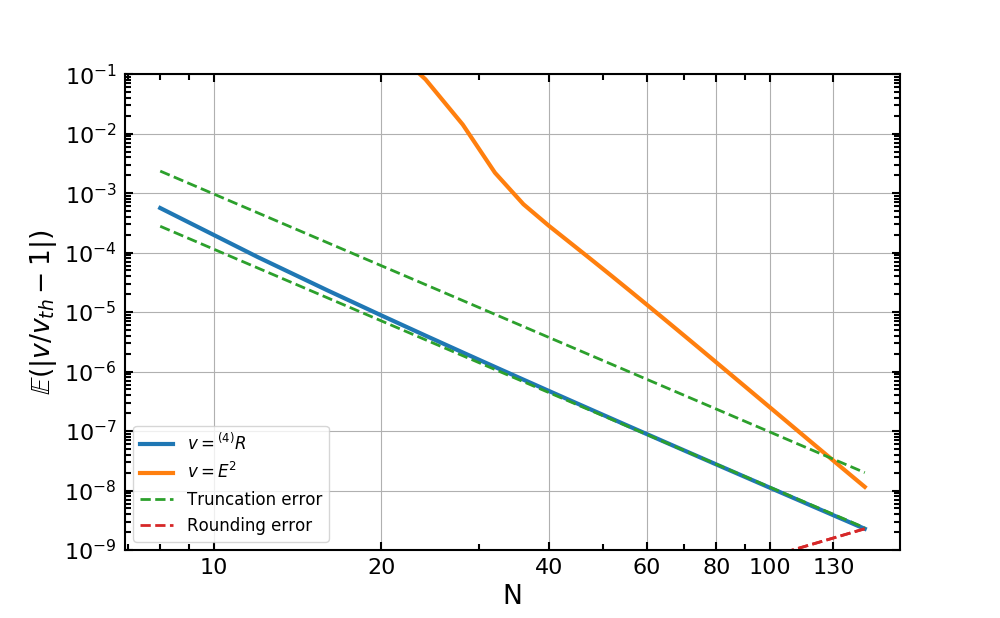

(1e-09, 0.1)

In [5]:
idec = -6
iinc = -1


phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))
plt.loglog(allNs, meanerror_4R, label=r'$v={}^{(4)}R$')
yplot_4th_order_decrease = [meanerror_4R[-20]*((allNs[-20]/N)**4) for N in allNs]
yplot_4th_order_increase = [meanerror_4R[iinc]*((N/allNs[iinc])**2.75) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=2)
plt.loglog(allNs, yplot_4th_order_increase, 'C3--', linewidth=2)

plt.loglog(allNs, meanerror_E2, color='C1', label=r'$v=E^2$')
yplot_4th_order_decrease = [meanerror_E2[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=2, label='Truncation error') #4th order increase

plt.loglog(allNs, yplot_4th_order_increase, 'C3--', linewidth=2, label='Rounding error')

plt.legend(loc=3, prop={'size': 12})
plt.grid()
plt.xlabel('N')
plt.xticks([10,20,40,60,80,100,130], ['10','20','40','60','80','100','130'])
plt.ylabel(r'$\mathbb{E}\left(|v/v_{th}-1|\right)$')
plt.ylim(1e-9, 1e-1)
#plt.savefig('./Plots/Szekeres_Geometrical.pdf')

In [4]:
import pandas as pd
data = np.array([allNs, meanerror_4R, meanerror_B2, meanerror_BT, meanerror_E2, meanerror_ET]).T
columns = ['N', '4R', 'B2', 'BT', 'E2', 'ET']
pd.DataFrame(data, columns=columns).to_csv('ErrorData/Szekeres_Geometrical_128bit.csv')